# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.55KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

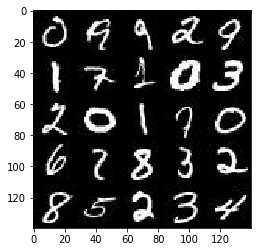

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

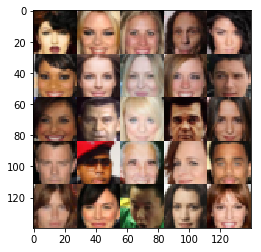

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_dimen = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dimen), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    keep_probability = 0.7
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST or 28x28x3 for CelebA
        # This is the 1st layer
        # No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 128, 4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, keep_probability)
        relu1 = LeakyReLU(x1)
        # 14x14x64 now
        #print('discriminator x1 shape ', x1.shape)
        
        # This is the 2nd layer
        x2 = tf.layers.conv2d(relu1, 256, 4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_probability)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = LeakyReLU(bn2)
        # 7x7x128 now
        #print('discriminator x2 shape ', x2.shape)
        
        # This is the 3rd layer
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, keep_probability)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = LeakyReLU(bn3)
        # 4x4x256 now
        #print('discriminator x3 shape ', x3.shape)

        # This is the 4th fully-connected layer
        # Flatten it
        #flat = tf.reshape(relu2, (-1, 7*7*128)) before adding additional layer
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        logits = tf.nn.dropout(logits, keep_probability)
        out = tf.sigmoid(logits)
    
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    keep_probability = 0.9 # eliminating dropout weakens generalization in Generator
    # print(out_channel_dim) <- value of 5 in unit test
    #output_dim = (28, 28, out_channel_dim)
    
    with tf.variable_scope('generator', reuse=not is_train): # <- not sure if reuse during training
        # 1st fully connected layer
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        #x1 = tf.nn.dropout(x1, keep_probability)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        # 2x2x512 now
        
        # This is the 2nd layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.nn.dropout(x2, keep_probability)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        # 7x7x256 now
        
        # This is the 3rd layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.nn.dropout(x3, keep_probability)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        # 14x14x128 now
        
        # This is the 4th, output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.nn.dropout(logits, keep_probability)
        # 28x28xout_channel_dim now        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5
                #  of 28x28 dimensional images.
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
        # show images at end of training
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7855 ... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 6.4493 ... Generator Loss: 0.2579
Epoch 1/2... Discriminator Loss: 2.0721 ... Generator Loss: 4.6660
Epoch 1/2... Discriminator Loss: 5.6682 ... Generator Loss: 10.2429
Epoch 1/2... Discriminator Loss: 4.1336 ... Generator Loss: 8.9185
Epoch 1/2... Discriminator Loss: 6.3145 ... Generator Loss: 7.2098
Epoch 1/2... Discriminator Loss: 3.7114 ... Generator Loss: 5.4837
Epoch 1/2... Discriminator Loss: 3.1906 ... Generator Loss: 5.1293
Epoch 1/2... Discriminator Loss: 1.8467 ... Generator Loss: 3.8641
Epoch 1/2... Discriminator Loss: 2.5125 ... Generator Loss: 2.8127


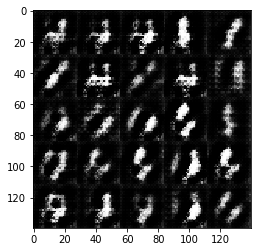

Epoch 1/2... Discriminator Loss: 2.3969 ... Generator Loss: 3.8433
Epoch 1/2... Discriminator Loss: 1.9092 ... Generator Loss: 3.1374
Epoch 1/2... Discriminator Loss: 2.4229 ... Generator Loss: 3.4445
Epoch 1/2... Discriminator Loss: 1.6448 ... Generator Loss: 2.5909
Epoch 1/2... Discriminator Loss: 2.5737 ... Generator Loss: 2.0097
Epoch 1/2... Discriminator Loss: 2.3844 ... Generator Loss: 1.8928
Epoch 1/2... Discriminator Loss: 1.6532 ... Generator Loss: 1.8126
Epoch 1/2... Discriminator Loss: 1.2723 ... Generator Loss: 1.5332
Epoch 1/2... Discriminator Loss: 1.8851 ... Generator Loss: 2.1202
Epoch 1/2... Discriminator Loss: 1.7300 ... Generator Loss: 1.6602


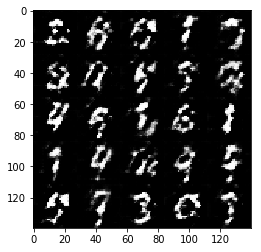

Epoch 1/2... Discriminator Loss: 1.6806 ... Generator Loss: 1.9430
Epoch 1/2... Discriminator Loss: 2.0052 ... Generator Loss: 1.7020
Epoch 1/2... Discriminator Loss: 1.4314 ... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.5892 ... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.6376 ... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 2.0546 ... Generator Loss: 0.3048
Epoch 1/2... Discriminator Loss: 1.1679 ... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.5535 ... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.8897 ... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.3183 ... Generator Loss: 0.6474


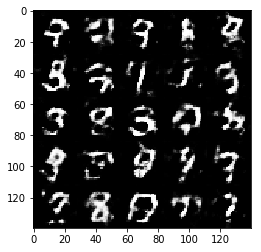

Epoch 1/2... Discriminator Loss: 1.7815 ... Generator Loss: 0.5170
Epoch 1/2... Discriminator Loss: 1.8053 ... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.5378 ... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.5569 ... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.2149 ... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.3125 ... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.5735 ... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 1.5077 ... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 1.5920 ... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.4069 ... Generator Loss: 0.7488


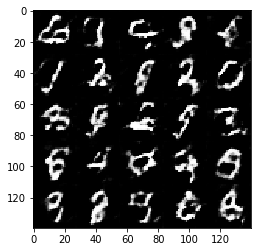

Epoch 1/2... Discriminator Loss: 1.3174 ... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 1.7711 ... Generator Loss: 1.5823
Epoch 1/2... Discriminator Loss: 2.1153 ... Generator Loss: 1.9779
Epoch 1/2... Discriminator Loss: 1.3593 ... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.4296 ... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.4125 ... Generator Loss: 1.2480
Epoch 1/2... Discriminator Loss: 1.3978 ... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.5928 ... Generator Loss: 0.4742
Epoch 1/2... Discriminator Loss: 1.3628 ... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.5838 ... Generator Loss: 0.4755


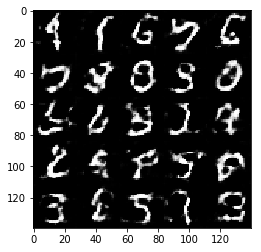

Epoch 1/2... Discriminator Loss: 1.3460 ... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.4340 ... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.2525 ... Generator Loss: 0.8954
Epoch 1/2... Discriminator Loss: 1.4551 ... Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 1.5297 ... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.5860 ... Generator Loss: 1.4988
Epoch 1/2... Discriminator Loss: 1.4187 ... Generator Loss: 1.3435
Epoch 1/2... Discriminator Loss: 1.3692 ... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 1.4251 ... Generator Loss: 1.0483
Epoch 1/2... Discriminator Loss: 1.7276 ... Generator Loss: 0.3583


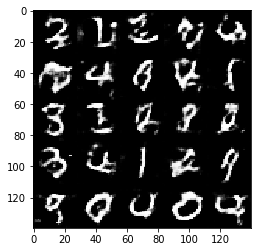

Epoch 1/2... Discriminator Loss: 2.0810 ... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 1.2863 ... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.4320 ... Generator Loss: 1.2834
Epoch 1/2... Discriminator Loss: 1.7244 ... Generator Loss: 0.3214
Epoch 1/2... Discriminator Loss: 1.4636 ... Generator Loss: 0.5403
Epoch 1/2... Discriminator Loss: 1.3158 ... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.2693 ... Generator Loss: 0.7930
Epoch 1/2... Discriminator Loss: 1.6092 ... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 1.7050 ... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.2948 ... Generator Loss: 1.1010


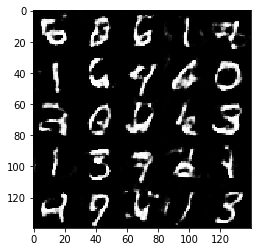

Epoch 1/2... Discriminator Loss: 1.4149 ... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 1.4475 ... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.4192 ... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.6922 ... Generator Loss: 1.2460
Epoch 1/2... Discriminator Loss: 1.2720 ... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.3249 ... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.1465 ... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.5389 ... Generator Loss: 1.1087
Epoch 1/2... Discriminator Loss: 1.3524 ... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.3026 ... Generator Loss: 1.0135


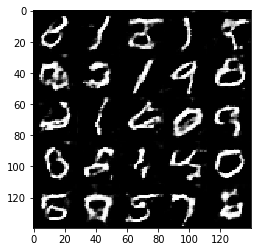

Epoch 1/2... Discriminator Loss: 1.4023 ... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 1.4043 ... Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 1.4718 ... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.4123 ... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.3030 ... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.5158 ... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.3817 ... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.2940 ... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.7459 ... Generator Loss: 0.4516
Epoch 1/2... Discriminator Loss: 1.2914 ... Generator Loss: 0.9212


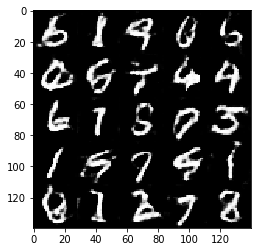

Epoch 1/2... Discriminator Loss: 1.4588 ... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 1.2997 ... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.2769 ... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.2178 ... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.2789 ... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 1.2870 ... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 1.4689 ... Generator Loss: 0.5559
Epoch 2/2... Discriminator Loss: 1.2058 ... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.3528 ... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 1.3937 ... Generator Loss: 0.9805


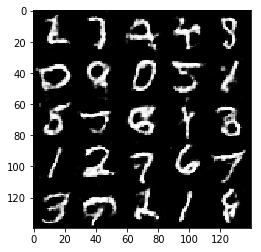

Epoch 2/2... Discriminator Loss: 1.1951 ... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.3961 ... Generator Loss: 0.6194
Epoch 2/2... Discriminator Loss: 1.4061 ... Generator Loss: 0.5310
Epoch 2/2... Discriminator Loss: 1.3727 ... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.4434 ... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.3473 ... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.3014 ... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 1.3904 ... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.5563 ... Generator Loss: 0.4550
Epoch 2/2... Discriminator Loss: 1.3417 ... Generator Loss: 0.8566


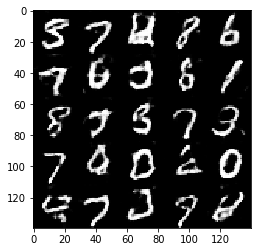

Epoch 2/2... Discriminator Loss: 1.5031 ... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.3989 ... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.3528 ... Generator Loss: 0.6338
Epoch 2/2... Discriminator Loss: 1.6029 ... Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 1.3277 ... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.2092 ... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.2515 ... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.5212 ... Generator Loss: 0.4916
Epoch 2/2... Discriminator Loss: 1.3892 ... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.3458 ... Generator Loss: 0.7374


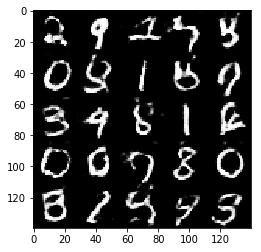

Epoch 2/2... Discriminator Loss: 1.4376 ... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.2118 ... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.2425 ... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.4126 ... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 1.2121 ... Generator Loss: 0.7627
Epoch 2/2... Discriminator Loss: 1.4151 ... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 1.4370 ... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.4358 ... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.2735 ... Generator Loss: 1.0902
Epoch 2/2... Discriminator Loss: 1.3337 ... Generator Loss: 0.5401


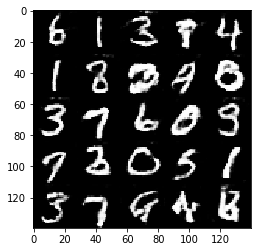

Epoch 2/2... Discriminator Loss: 1.3088 ... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.5511 ... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.2711 ... Generator Loss: 1.0810
Epoch 2/2... Discriminator Loss: 1.5604 ... Generator Loss: 0.4937
Epoch 2/2... Discriminator Loss: 1.5349 ... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 1.2162 ... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.2984 ... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.3660 ... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.5838 ... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.2364 ... Generator Loss: 0.8252


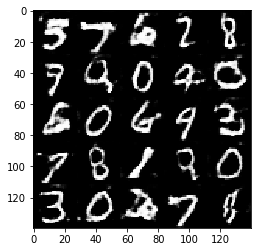

Epoch 2/2... Discriminator Loss: 1.2272 ... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.2229 ... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.3276 ... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.2258 ... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.2336 ... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.2922 ... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.2279 ... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.7992 ... Generator Loss: 0.3625
Epoch 2/2... Discriminator Loss: 1.3656 ... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.3667 ... Generator Loss: 0.6032


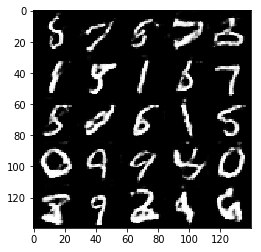

Epoch 2/2... Discriminator Loss: 1.3388 ... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.3569 ... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 1.2888 ... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.3466 ... Generator Loss: 0.9883
Epoch 2/2... Discriminator Loss: 1.2204 ... Generator Loss: 0.8108
Epoch 2/2... Discriminator Loss: 1.3141 ... Generator Loss: 0.9086
Epoch 2/2... Discriminator Loss: 1.3757 ... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.4242 ... Generator Loss: 1.2767
Epoch 2/2... Discriminator Loss: 1.4041 ... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 1.3118 ... Generator Loss: 0.5818


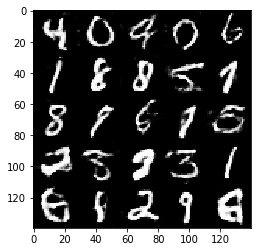

Epoch 2/2... Discriminator Loss: 1.3033 ... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 1.2358 ... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 1.2811 ... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.2092 ... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.3995 ... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 1.3371 ... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.3660 ... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.2986 ... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.3281 ... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.2327 ... Generator Loss: 0.8217


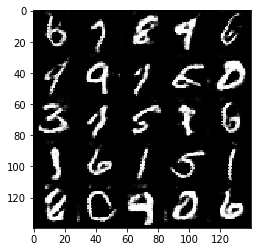

Epoch 2/2... Discriminator Loss: 1.2206 ... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.7012 ... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 1.3497 ... Generator Loss: 0.5485
Epoch 2/2... Discriminator Loss: 1.3009 ... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.2311 ... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.4598 ... Generator Loss: 1.5108
Epoch 2/2... Discriminator Loss: 1.3395 ... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.2630 ... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.4148 ... Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 1.3125 ... Generator Loss: 1.1300


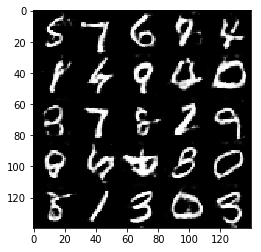

Epoch 2/2... Discriminator Loss: 1.2095 ... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 1.2358 ... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.1548 ... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.3052 ... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 1.2666 ... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 1.6377 ... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 1.2278 ... Generator Loss: 0.7714


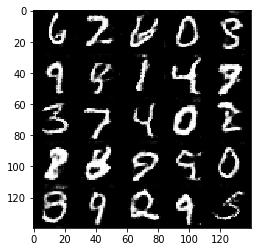

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.1

# https://discussions.udacity.com/t/project-facegeneration-indexerror-list-index-out-of-range/246401
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4339 ... Generator Loss: 3.7108
Epoch 1/1... Discriminator Loss: 2.0044 ... Generator Loss: 5.3274
Epoch 1/1... Discriminator Loss: 1.5077 ... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3169 ... Generator Loss: 5.2026
Epoch 1/1... Discriminator Loss: 1.2973 ... Generator Loss: 8.0802
Epoch 1/1... Discriminator Loss: 0.8876 ... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 0.7966 ... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 1.0233 ... Generator Loss: 3.3822
Epoch 1/1... Discriminator Loss: 0.9829 ... Generator Loss: 2.0749
Epoch 1/1... Discriminator Loss: 1.0279 ... Generator Loss: 1.2408


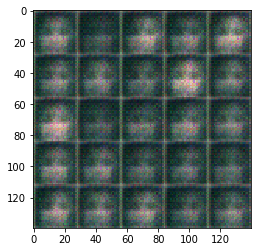

Epoch 1/1... Discriminator Loss: 1.8095 ... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.3575 ... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1651 ... Generator Loss: 3.3404
Epoch 1/1... Discriminator Loss: 1.2215 ... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.0390 ... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.5191 ... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.6959 ... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.1196 ... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.2558 ... Generator Loss: 2.6183
Epoch 1/1... Discriminator Loss: 1.0198 ... Generator Loss: 1.2901


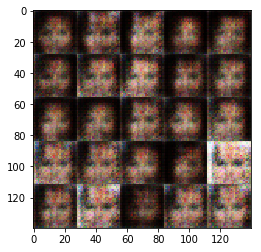

Epoch 1/1... Discriminator Loss: 1.1588 ... Generator Loss: 2.1571
Epoch 1/1... Discriminator Loss: 1.3217 ... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 1.3100 ... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.2240 ... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 1.2684 ... Generator Loss: 1.7022
Epoch 1/1... Discriminator Loss: 1.8343 ... Generator Loss: 2.2760
Epoch 1/1... Discriminator Loss: 1.5237 ... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.4612 ... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4974 ... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3700 ... Generator Loss: 1.0176


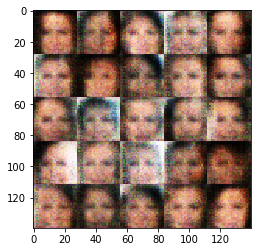

Epoch 1/1... Discriminator Loss: 1.8375 ... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.2489 ... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3631 ... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.1253 ... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 1.1833 ... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.1991 ... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 1.6137 ... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4516 ... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 1.1196 ... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.5069 ... Generator Loss: 2.0523


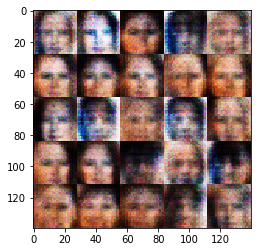

Epoch 1/1... Discriminator Loss: 1.4631 ... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 1.2347 ... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 1.0250 ... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.3132 ... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.9714 ... Generator Loss: 1.3978
Epoch 1/1... Discriminator Loss: 1.5917 ... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 1.0679 ... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.6322 ... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 0.9107 ... Generator Loss: 1.4174
Epoch 1/1... Discriminator Loss: 1.2189 ... Generator Loss: 2.1507


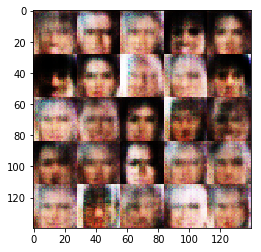

Epoch 1/1... Discriminator Loss: 1.0124 ... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 1.2825 ... Generator Loss: 2.4769
Epoch 1/1... Discriminator Loss: 1.4534 ... Generator Loss: 2.2131
Epoch 1/1... Discriminator Loss: 1.0611 ... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 1.2747 ... Generator Loss: 1.7592
Epoch 1/1... Discriminator Loss: 1.0942 ... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 1.2030 ... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.0922 ... Generator Loss: 1.9060
Epoch 1/1... Discriminator Loss: 1.2649 ... Generator Loss: 1.8808
Epoch 1/1... Discriminator Loss: 0.9946 ... Generator Loss: 1.1954


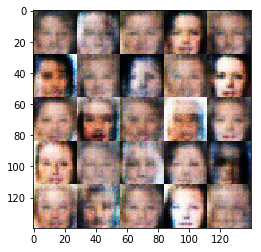

Epoch 1/1... Discriminator Loss: 1.4976 ... Generator Loss: 2.2254
Epoch 1/1... Discriminator Loss: 1.2022 ... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 1.3905 ... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 1.1462 ... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.0110 ... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1717 ... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 1.1468 ... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 1.1855 ... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.2764 ... Generator Loss: 2.0344
Epoch 1/1... Discriminator Loss: 1.6749 ... Generator Loss: 2.8004


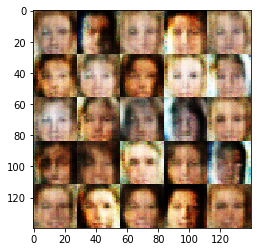

Epoch 1/1... Discriminator Loss: 1.2821 ... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4576 ... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.0554 ... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 1.1715 ... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 1.1412 ... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 1.3300 ... Generator Loss: 2.1625
Epoch 1/1... Discriminator Loss: 1.0322 ... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.3000 ... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.2363 ... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3353 ... Generator Loss: 0.5643


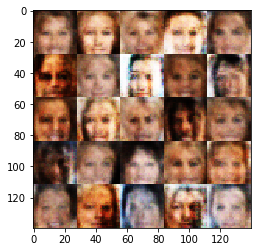

Epoch 1/1... Discriminator Loss: 1.3625 ... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.1031 ... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.3135 ... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.2874 ... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.1576 ... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2560 ... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.1557 ... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.3278 ... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3409 ... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.2920 ... Generator Loss: 1.1340


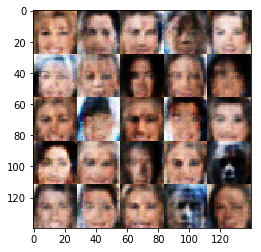

Epoch 1/1... Discriminator Loss: 1.3215 ... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.3018 ... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2820 ... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1979 ... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.1696 ... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 1.2550 ... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 1.6751 ... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.4103 ... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.4191 ... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4453 ... Generator Loss: 1.7603


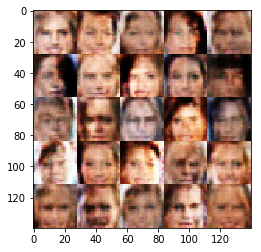

Epoch 1/1... Discriminator Loss: 1.1417 ... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.1586 ... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.4384 ... Generator Loss: 1.8872
Epoch 1/1... Discriminator Loss: 1.1202 ... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 1.3023 ... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 1.1561 ... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2221 ... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.3019 ... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.1201 ... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 1.2276 ... Generator Loss: 1.0763


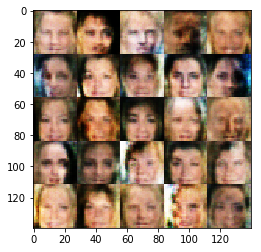

Epoch 1/1... Discriminator Loss: 1.2704 ... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.7059 ... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.3691 ... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2670 ... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.5911 ... Generator Loss: 2.0066
Epoch 1/1... Discriminator Loss: 1.1775 ... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3635 ... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3376 ... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.1482 ... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.4065 ... Generator Loss: 1.8742


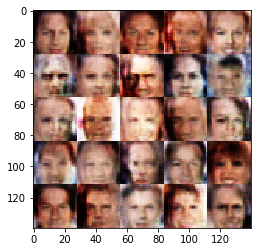

Epoch 1/1... Discriminator Loss: 1.2147 ... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 1.3459 ... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.1788 ... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3366 ... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4165 ... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.4771 ... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4352 ... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4161 ... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.1535 ... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.1817 ... Generator Loss: 0.8918


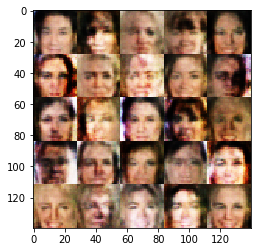

Epoch 1/1... Discriminator Loss: 1.3495 ... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.2293 ... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.5627 ... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.5945 ... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.2049 ... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3741 ... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2846 ... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 1.6475 ... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.3111 ... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3701 ... Generator Loss: 1.4034


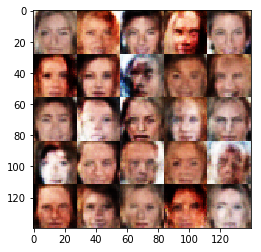

Epoch 1/1... Discriminator Loss: 1.1382 ... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.0913 ... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.1598 ... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.1356 ... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 0.8242 ... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 1.2766 ... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 1.0836 ... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2820 ... Generator Loss: 2.1469
Epoch 1/1... Discriminator Loss: 1.4488 ... Generator Loss: 2.1873
Epoch 1/1... Discriminator Loss: 1.0532 ... Generator Loss: 1.8024


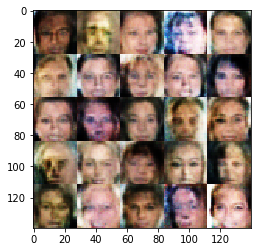

Epoch 1/1... Discriminator Loss: 1.0382 ... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.0803 ... Generator Loss: 1.6413
Epoch 1/1... Discriminator Loss: 1.2912 ... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 1.0019 ... Generator Loss: 1.8611
Epoch 1/1... Discriminator Loss: 1.2308 ... Generator Loss: 2.5039
Epoch 1/1... Discriminator Loss: 1.1716 ... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.0826 ... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.5749 ... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 0.9324 ... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 1.0980 ... Generator Loss: 0.9508


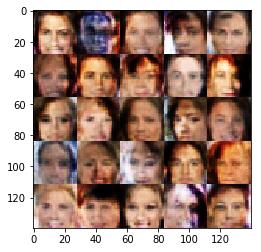

Epoch 1/1... Discriminator Loss: 1.1450 ... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 1.0148 ... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.1120 ... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 0.9981 ... Generator Loss: 1.5782
Epoch 1/1... Discriminator Loss: 0.9138 ... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.0856 ... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 1.0357 ... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.0902 ... Generator Loss: 2.1915
Epoch 1/1... Discriminator Loss: 1.2288 ... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 0.9383 ... Generator Loss: 1.3079


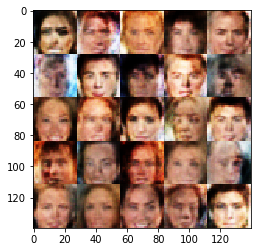

Epoch 1/1... Discriminator Loss: 1.2156 ... Generator Loss: 2.5005
Epoch 1/1... Discriminator Loss: 1.6785 ... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.3780 ... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.5858 ... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.4016 ... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.5536 ... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.7903 ... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.1706 ... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.5965 ... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.4068 ... Generator Loss: 0.5287


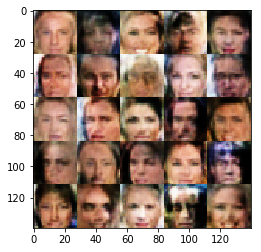

Epoch 1/1... Discriminator Loss: 1.1308 ... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.1573 ... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4905 ... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.2243 ... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.1838 ... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.0597 ... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 0.9967 ... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3335 ... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.5057 ... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.3078 ... Generator Loss: 0.5977


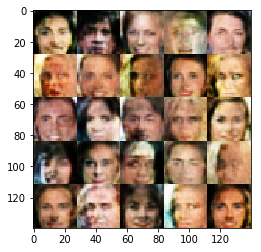

Epoch 1/1... Discriminator Loss: 1.5904 ... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.0131 ... Generator Loss: 2.6402
Epoch 1/1... Discriminator Loss: 1.0071 ... Generator Loss: 2.2286
Epoch 1/1... Discriminator Loss: 1.0970 ... Generator Loss: 2.2699
Epoch 1/1... Discriminator Loss: 1.2061 ... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 1.0204 ... Generator Loss: 1.8533
Epoch 1/1... Discriminator Loss: 0.9377 ... Generator Loss: 1.6617
Epoch 1/1... Discriminator Loss: 0.9174 ... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 1.2983 ... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.6583 ... Generator Loss: 0.4502


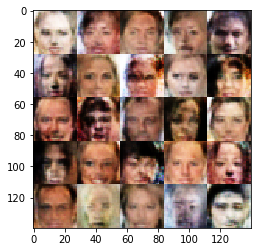

Epoch 1/1... Discriminator Loss: 1.6865 ... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 0.8986 ... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 1.2056 ... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 1.1378 ... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 1.0802 ... Generator Loss: 2.6783
Epoch 1/1... Discriminator Loss: 1.3065 ... Generator Loss: 1.7214
Epoch 1/1... Discriminator Loss: 1.3751 ... Generator Loss: 3.0430
Epoch 1/1... Discriminator Loss: 1.2306 ... Generator Loss: 2.3849
Epoch 1/1... Discriminator Loss: 1.0426 ... Generator Loss: 2.4628
Epoch 1/1... Discriminator Loss: 0.9458 ... Generator Loss: 1.7048


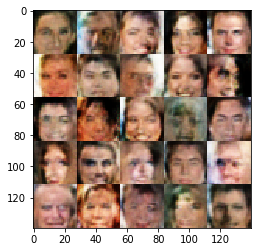

Epoch 1/1... Discriminator Loss: 1.1824 ... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.7671 ... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 0.7691 ... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 0.9097 ... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.9562 ... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 0.9400 ... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.8999 ... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.9365 ... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.2039 ... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.9537 ... Generator Loss: 1.9305


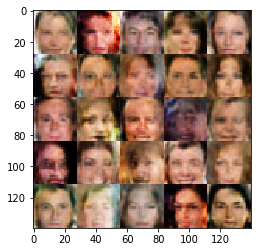

Epoch 1/1... Discriminator Loss: 0.9265 ... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1474 ... Generator Loss: 1.9460
Epoch 1/1... Discriminator Loss: 1.1061 ... Generator Loss: 1.6730
Epoch 1/1... Discriminator Loss: 1.2989 ... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4189 ... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.2512 ... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3740 ... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4877 ... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.3373 ... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3682 ... Generator Loss: 0.5659


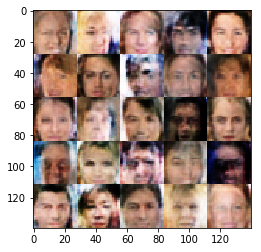

Epoch 1/1... Discriminator Loss: 1.1508 ... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.8560 ... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.0684 ... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.4402 ... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.3347 ... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.0559 ... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4380 ... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.1345 ... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5006 ... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.1028 ... Generator Loss: 0.7475


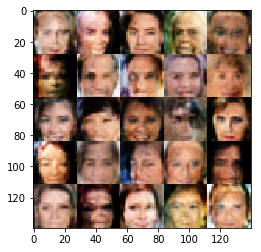

Epoch 1/1... Discriminator Loss: 1.1257 ... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.8960 ... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.2090 ... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.3898 ... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 0.9470 ... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 1.1624 ... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 1.0706 ... Generator Loss: 2.0543
Epoch 1/1... Discriminator Loss: 1.3709 ... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 1.1662 ... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.0784 ... Generator Loss: 1.0431


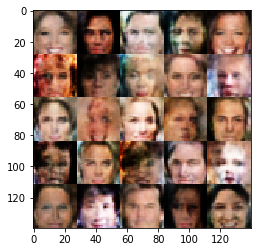

Epoch 1/1... Discriminator Loss: 0.8943 ... Generator Loss: 1.7160
Epoch 1/1... Discriminator Loss: 1.0496 ... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 0.9056 ... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 1.0126 ... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 1.3457 ... Generator Loss: 2.3438
Epoch 1/1... Discriminator Loss: 0.9795 ... Generator Loss: 1.7551
Epoch 1/1... Discriminator Loss: 1.1680 ... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 0.9907 ... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.2726 ... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3157 ... Generator Loss: 0.5813


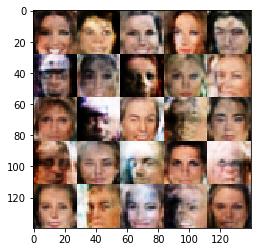

Epoch 1/1... Discriminator Loss: 0.9794 ... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.5465 ... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.4090 ... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.1490 ... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.8131 ... Generator Loss: 2.2725
Epoch 1/1... Discriminator Loss: 0.9304 ... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 1.1577 ... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 1.1146 ... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 1.3175 ... Generator Loss: 2.4851
Epoch 1/1... Discriminator Loss: 1.1630 ... Generator Loss: 0.6868


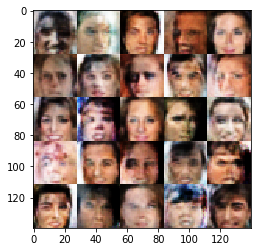

Epoch 1/1... Discriminator Loss: 0.9086 ... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.4375 ... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.2515 ... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 0.9831 ... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.5280 ... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.3378 ... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.4448 ... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.5560 ... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.3489 ... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 0.9656 ... Generator Loss: 1.0733


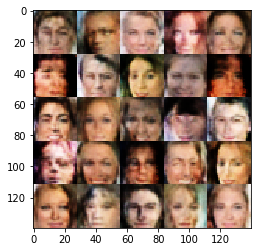

Epoch 1/1... Discriminator Loss: 0.9917 ... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.2573 ... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.0336 ... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.0858 ... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.0672 ... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.8236 ... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 0.9297 ... Generator Loss: 1.8771
Epoch 1/1... Discriminator Loss: 1.2382 ... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 0.9381 ... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 1.0952 ... Generator Loss: 1.6242


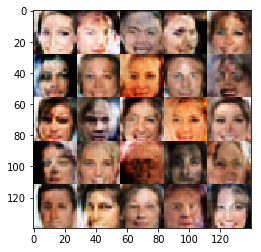

Epoch 1/1... Discriminator Loss: 0.9911 ... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.8941 ... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.0984 ... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 0.7866 ... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.0904 ... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.1206 ... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.1872 ... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.6986 ... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 0.9991 ... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.3756 ... Generator Loss: 1.8094


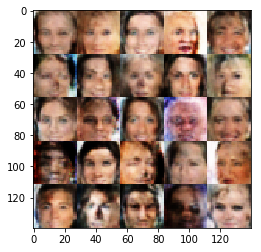

Epoch 1/1... Discriminator Loss: 1.4066 ... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 1.2685 ... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.9305 ... Generator Loss: 1.7335
Epoch 1/1... Discriminator Loss: 0.9778 ... Generator Loss: 2.0459
Epoch 1/1... Discriminator Loss: 0.8371 ... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 1.1994 ... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 1.0869 ... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 1.0356 ... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.2967 ... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 0.9551 ... Generator Loss: 0.9393


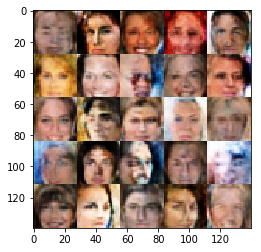

Epoch 1/1... Discriminator Loss: 0.8863 ... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 1.0740 ... Generator Loss: 2.4716
Epoch 1/1... Discriminator Loss: 1.0733 ... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 0.9284 ... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.5135 ... Generator Loss: 2.0623
Epoch 1/1... Discriminator Loss: 0.8188 ... Generator Loss: 1.2366


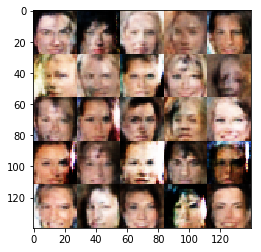

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.